In [17]:
!pip install -q roboflow albumentations ultralytics
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import albumentations as A
import random
import numpy as np
from pathlib import Path

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="hr9lzB96MhmoITXPgPkI")
project = rf.workspace("ro-3i1oa").project("rice-disease-hlngq")
version = project.version(5)
dataset = version.download("yolov12")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 39.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 102.6 MB/s eta 0:00:0000:01
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-s


Extracting Dataset Version Zip to rice-disease-5 in yolov12:: 100%|██████████| 15858/15858 [00:01<00:00, 8151.42it/s] 


In [14]:
# ────────────────────────────────────────────────────────
# 3. CLONE YOLOv12 REPOSITORY
# ────────────────────────────────────────────────────────

print("\n" + "="*60)
print("📦 SETTING UP YOLOv12")
print("="*60)

yolov12_dir = Path("/kaggle/working/yolov12")

if not yolov12_dir.exists():
    print("Cloning YOLOv12 repository...")
    !git clone https://github.com/sunsmarterjie/yolov12.git
    %cd yolov12
    !pip install -q -r requirements.txt
    !pip install -q -e .
    print("✅ YOLOv12 installed")
else:
    print("YOLOv12 already exists, skipping clone...")
    %cd /kaggle/working/yolov12

print("✅ YOLOv12 setup completed")


📦 SETTING UP YOLOv12
YOLOv12 already exists, skipping clone...
/kaggle/working/yolov12
✅ YOLOv12 setup completed


In [5]:
# --- CẤU HÌNH ---
DATASET_PATH = '/kaggle/working/rice-disease-5'
YAML_PATH = os.path.join(DATASET_PATH, 'data.yaml')
TARGET_CLASS_NAME = "Healthy" 

# 1. Đọc tên các lớp từ file YAML
with open(YAML_PATH, 'r') as f:
    data_yaml = yaml.safe_load(f)
class_names = data_yaml['names']

# 2. Hàm phân tích từng tập (train/val/test)
def analyze_split(split):
    label_path = os.path.join(DATASET_PATH, split, 'labels')
    data_list = []
    
    if not os.path.exists(label_path):
        return []

    for label_file in os.listdir(label_path):
        # Kiểm tra nếu là ảnh Augmentation (Roboflow thường thêm mã băm hoặc _aug)
        # Cách nhận diện: Tên file có nhiều hơn 1 dấu gạch dưới hoặc chứa chuỗi ký tự lạ
        is_aug = "_" in label_file and any(char.isdigit() for char in label_file)
        img_type = "Augmented" if is_aug else "Original"
        
        file_path = os.path.join(label_path, label_file)
        with open(file_path, 'r') as f:
            lines = f.readlines()
            # Lấy danh sách các class ID duy nhất trong ảnh này
            present_classes = set([int(line.split()[0]) for line in lines])
            
            for cls_id in present_classes:
                data_list.append({
                    'Split': split,
                    'Class_Name': class_names[cls_id],
                    'Type': img_type,
                    'Is_Healthy': TARGET_CLASS_NAME.lower() in class_names[cls_id].lower()
                })
    return data_list

# 3. Tổng hợp dữ liệu
all_data = []
for s in ['train', 'valid', 'test']:
    all_data.extend(analyze_split(s))

df = pd.DataFrame(all_data)

# 4. Hiển thị bảng tổng hợp
print("--- THỐNG KÊ CHI TIẾT ---")
summary = df.groupby(['Split', 'Class_Name', 'Type']).size().unstack(fill_value=0)
print(summary)


# 5. Xác nhận các lớp sẽ bị xóa
target_classes = [name for name in class_names if TARGET_CLASS_NAME.lower() in name.lower()]
print(f"\n[CHÚ Ý] Các lớp chứa từ khóa '{TARGET_CLASS_NAME}': {target_classes}")

--- THỐNG KÊ CHI TIẾT ---
Type                         Augmented
Split Class_Name                      
test  Bacterial Leaf Blight         63
      Brown Spot                    61
      Healthy                       14
      Leaf Blast                    60
      Leaf Scald                    59
      Sheath Blight                 64
train Bacterial Leaf Blight       1317
      Brown Spot                  1317
      Healthy                      348
      Leaf Blast                  1275
      Leaf Scald                  1275
      Sheath Blight               1299
valid Bacterial Leaf Blight        124
      Brown Spot                   124
      Healthy                       34
      Leaf Blast                   121
      Leaf Scald                   119
      Sheath Blight                125

[CHÚ Ý] Các lớp chứa từ khóa 'Healthy': ['Healthy']


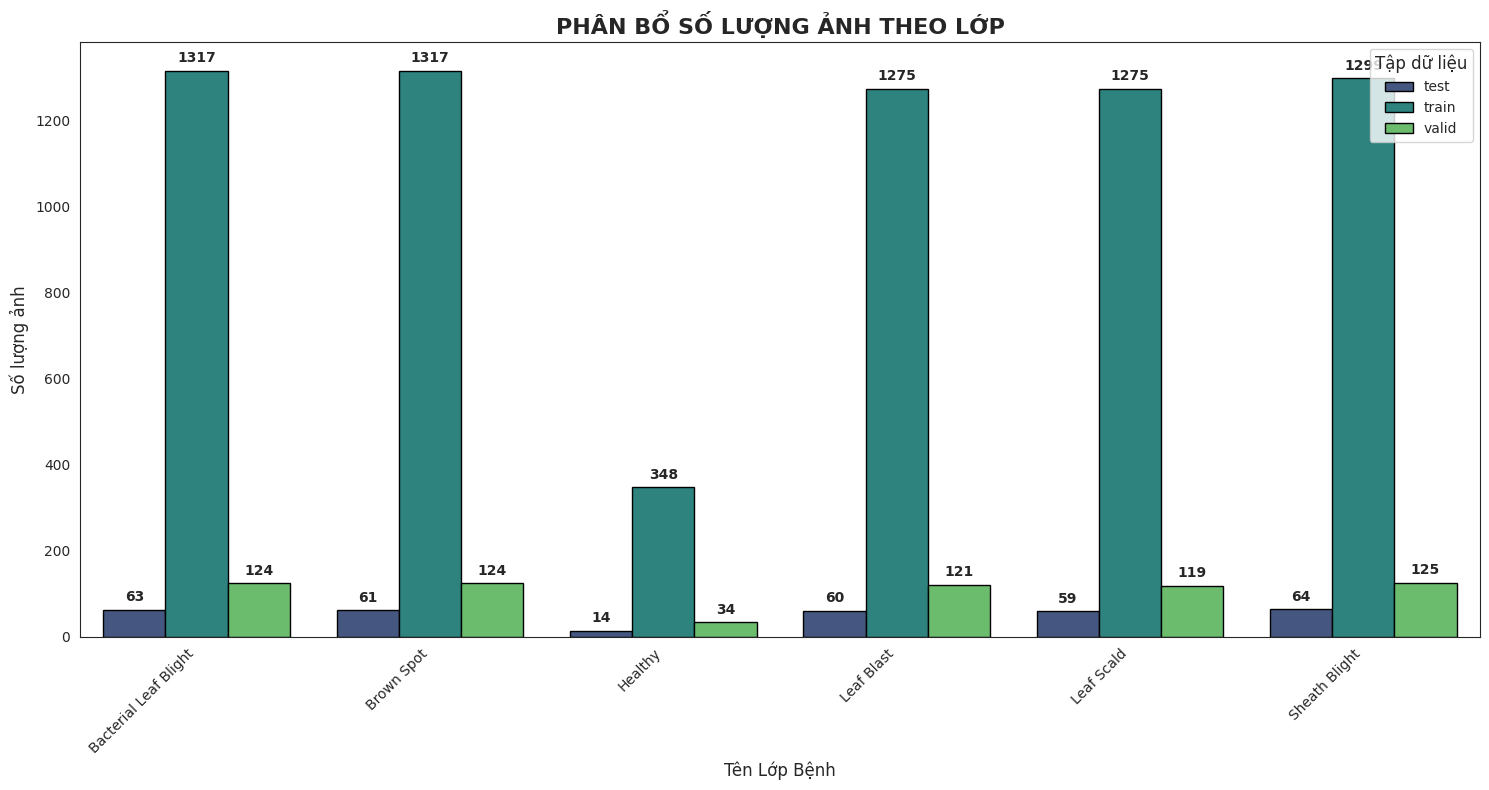


--- BẢNG SỐ LIỆU CHI TIẾT ---
Split                  train  valid  test
Class_Name                               
Bacterial Leaf Blight   1317    124    63
Brown Spot              1317    124    61
Healthy                  348     34    14
Leaf Blast              1275    121    60
Leaf Scald              1275    119    59
Sheath Blight           1299    125    64


In [6]:
# Tế bào này chạy sau khi bạn đã có biến 'df' từ đoạn code thống kê trước đó

# 1. Chuẩn bị dữ liệu: Nhóm theo Lớp và Tập dữ liệu
plot_df = df.groupby(['Class_Name', 'Split']).size().reset_index(name='Count')

# 2. Thiết lập giao diện biểu đồ
plt.figure(figsize=(15, 8))
sns.set_style("white")

# 3. Vẽ biểu đồ cột nhóm (Grouped Bar Chart)
ax = sns.barplot(data=plot_df, x='Class_Name', y='Count', hue='Split', 
                 palette='viridis', edgecolor='black')

# 4. Thêm số liệu cụ thể trên đầu mỗi cột để dễ trích dẫn vào báo cáo
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize=10, fontweight='bold')

# 5. Tinh chỉnh tiêu đề và nhãn
plt.title('PHÂN BỔ SỐ LƯỢNG ẢNH THEO LỚP', fontsize=16, fontweight='bold')
plt.xlabel('Tên Lớp Bệnh', fontsize=12)
plt.ylabel('Số lượng ảnh', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tập dữ liệu', title_fontsize='12', loc='upper right')

plt.tight_layout()
plt.show()

# 6. Xuất thêm bảng số liệu dạng ma trận để copy vào Word/Excel
print("\n--- BẢNG SỐ LIỆU CHI TIẾT ---")
pivot_table = plot_df.pivot(index='Class_Name', columns='Split', values='Count').fillna(0).astype(int)
# Sắp xếp lại cột cho đúng thứ tự thông thường
pivot_table = pivot_table[['train', 'valid', 'test']]
print(pivot_table)

In [7]:
# --- 1. TÍNH TOÁN SỐ LƯỢNG MỤC TIÊU ---
# Giả sử bạn đã có dataframe 'df' từ code thống kê trước đó
# Chúng ta chỉ tính trên tập 'train' vì chỉ nên augment tập train
train_df = df[df['Split'] == 'train']
stats = train_df.groupby('Class_Name').size()

# Lấy số lượng của các lớp KHÔNG PHẢI Healthy
other_classes_stats = stats[stats.index != TARGET_CLASS_NAME]
target_count = int(other_classes_stats.mean()) # Lấy trung bình cộng các lớp bệnh

print(f"Số lượng trung bình các lớp bệnh khác: {target_count}")

# --- 2. CẤU HÌNH ĐƯỜNG DẪN ---
TRAIN_IMG_PATH = os.path.join(DATASET_PATH, 'train', 'images')
TRAIN_LBL_PATH = os.path.join(DATASET_PATH, 'train', 'labels')
HEALTHY_CLASS_ID = class_names.index(TARGET_CLASS_NAME)

# Định nghĩa các phép biến đổi
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
])

# --- 3. TÌM ẢNH HEALTHY HIỆN CÓ ---
healthy_files = []
for lbl_file in os.listdir(TRAIN_LBL_PATH):
    with open(os.path.join(TRAIN_LBL_PATH, lbl_file), 'r') as f:
        if any(int(line.split()[0]) == HEALTHY_CLASS_ID for line in f.readlines()):
            healthy_files.append(lbl_file.replace('.txt', ''))

current_healthy_count = len(healthy_files)
needed_count = target_count - current_healthy_count

print(f"Lớp Healthy hiện có: {current_healthy_count}")

# --- 4. THỰC HIỆN AUGMENTATION ĐỂ CÂN BẰNG ---
if needed_count > 0:
    print(f"Đang tiến hành tạo thêm {needed_count} ảnh để cân bằng...")
    for i in range(needed_count):
        base_name = random.choice(healthy_files)
        
        # Tìm file ảnh
        img_ext = None
        for ext in ['.jpg', '.png', '.jpeg']:
            if os.path.exists(os.path.join(TRAIN_IMG_PATH, base_name + ext)):
                img_ext = ext
                break
        
        if img_ext:
            # Đọc ảnh và nhãn
            image = cv2.imread(os.path.join(TRAIN_IMG_PATH, base_name + img_ext))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            with open(os.path.join(TRAIN_LBL_PATH, base_name + ".txt"), 'r') as f:
                label_content = f.read()

            # Augment
            augmented = transform(image=image)
            aug_img = augmented['image']
            
            # Lưu file mới
            new_name = f"aug_balanced_{i}_{base_name}"
            cv2.imwrite(os.path.join(TRAIN_IMG_PATH, new_name + img_ext), 
                        cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
            with open(os.path.join(TRAIN_LBL_PATH, new_name + ".txt"), 'w') as f:
                f.write(label_content)

    print("Hoàn thành! Dataset đã được cân bằng.")
else:
    print("Số lượng lớp Healthy đã đủ hoặc vượt mức trung bình, không cần Augment.")

Số lượng trung bình các lớp bệnh khác: 1296
Lớp Healthy hiện có: 348
Đang tiến hành tạo thêm 948 ảnh để cân bằng...
Hoàn thành! Dataset đã được cân bằng.


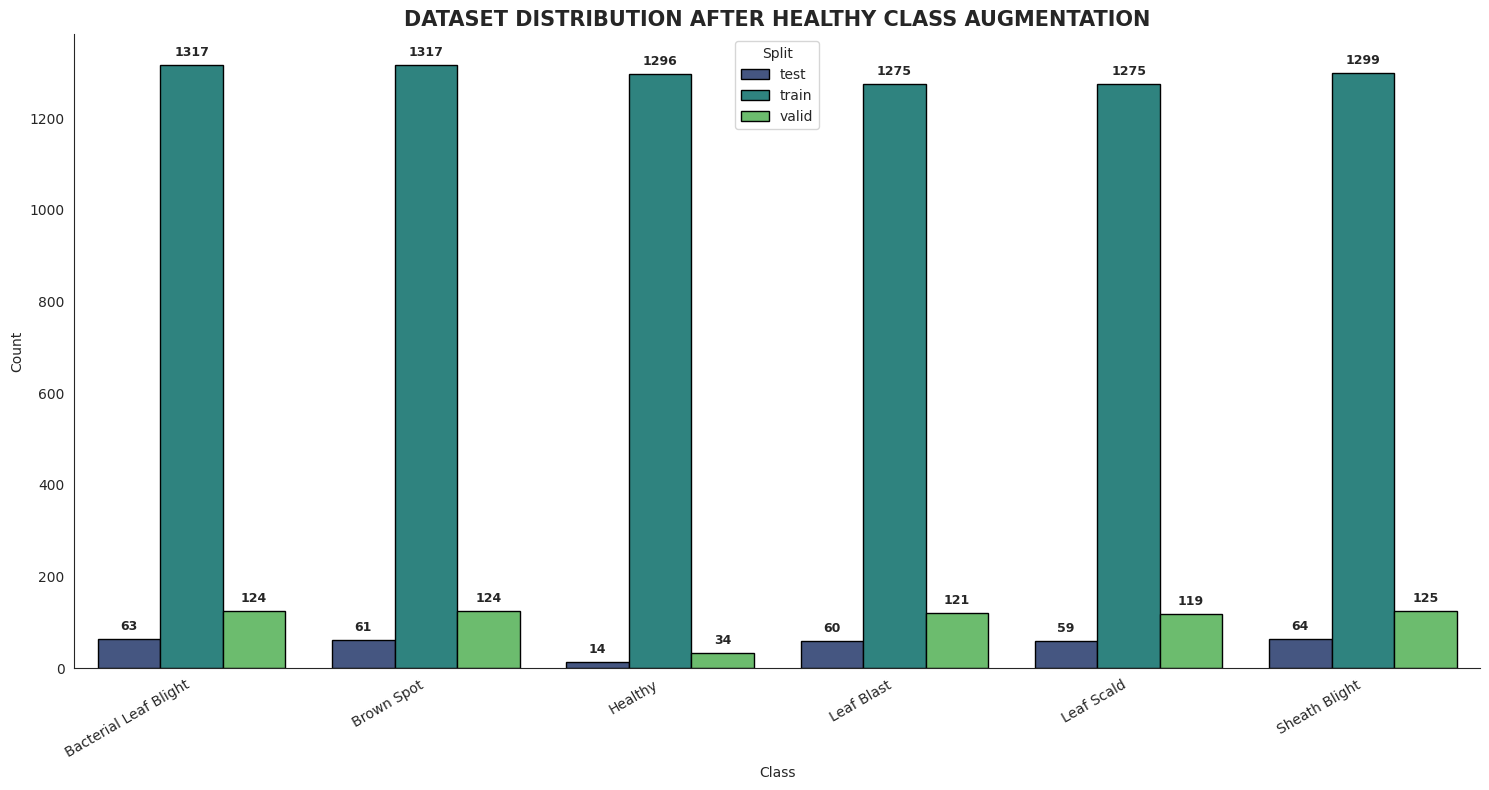

In [9]:
results_list = []
for split in ['test', 'train', 'valid']:
    label_path = os.path.join(DATASET_PATH, split, 'labels')
    stats = {name: 0 for name in class_names}
    if os.path.exists(label_path):
        for lbl in os.listdir(label_path):
            with open(os.path.join(label_path, lbl), 'r') as f:
                indices = set([int(line.split()[0]) for line in f.readlines()])
                for idx in indices: stats[class_names[idx]] += 1
    for cls, count in stats.items():
        results_list.append({'Split': split, 'Class': cls, 'Count': count})

df_after = pd.DataFrame(results_list)
df_after['Split'] = pd.Categorical(df_after['Split'], categories=['test', 'train', 'valid'], ordered=True)

# --- 3. VẼ BIỂU ĐỒ (PLOT) ---

plt.figure(figsize=(15, 8))
sns.set_style("white")
ax = sns.barplot(data=df_after, x='Class', y='Count', hue='Split', palette='viridis', edgecolor='black')

for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=9, fontweight='bold')

plt.title('DATASET DISTRIBUTION AFTER HEALTHY CLASS AUGMENTATION', fontsize=15, fontweight='bold')
plt.xticks(rotation=30, ha='right')
plt.grid(False)
sns.despine()
plt.tight_layout()
plt.show()

In [10]:
print("\n--- SUMMARY TABLE ---")
print(df_after.pivot(index='Class', columns='Split', values='Count').fillna(0).astype(int))


--- SUMMARY TABLE ---
Split                  test  train  valid
Class                                    
Bacterial Leaf Blight    63   1317    124
Brown Spot               61   1317    124
Healthy                  14   1296     34
Leaf Blast               60   1275    121
Leaf Scald               59   1275    119
Sheath Blight            64   1299    125


In [15]:
# ────────────────────────────────────────────────────────
# 8. CREATE YOLOv12 YAML
# ────────────────────────────────────────────────────────

print("\n" + "="*60)
print("📝 CREATING YOLOv12 CONFIG")
print("="*60)

yolov12_yaml = f"""
nc: {len(class_names)}
scales:
  n: [0.33, 0.25, 0.50]

backbone:
  - [-1, 1, Conv, [64, 3, 2]]
  - [-1, 1, Conv, [128, 3, 2]]
  - [-1, 3, C3k2, [256, False, 0.25]]
  - [-1, 1, Conv, [256, 3, 2]]
  - [-1, 6, C3k2, [512, False, 0.25]]
  - [-1, 1, Conv, [512, 3, 2]]
  - [-1, 6, C3k2, [512, True]]
  - [-1, 1, Conv, [1024, 3, 2]]
  - [-1, 3, C3k2, [1024, True]]
  - [-1, 1, SPPF, [1024, 5]]

head:
  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 6], 1, Concat, [1]]
  - [-1, 3, C3k2, [512, False]]
  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 4], 1, Concat, [1]]
  - [-1, 3, C3k2, [256, False]]
  - [-1, 1, Conv, [256, 3, 2]]
  - [[-1, 12], 1, Concat, [1]]
  - [-1, 3, C3k2, [512, False]]
  - [-1, 1, Conv, [512, 3, 2]]
  - [[-1, 9], 1, Concat, [1]]
  - [-1, 3, C3k2, [1024, True]]
  - [[15, 18, 21], 1, Detect, [nc]]
"""

yaml_path = Path("/kaggle/working/yolov12n_multiscale.yaml")
with open(yaml_path, 'w') as f:
    f.write(yolov12_yaml)

print(f"✅ Config saved: {yaml_path}")

# ────────────────────────────────────────────────────────
# 9. LOAD MODEL & TRAIN
# ────────────────────────────────────────────────────────

print("\n" + "="*60)
print("🚀 LOADING MODEL & TRAINING")
print("="*60)

from ultralytics import YOLO

model = YOLO(str(yaml_path))
print("✅ Model loaded")


📝 CREATING YOLOv12 CONFIG
✅ Config saved: /kaggle/working/yolov12n_multiscale.yaml

🚀 LOADING MODEL & TRAINING
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
✅ Model loaded


In [ ]:
# --- 5. Bắt đầu Train ---
results = model.train(
    data='/kaggle/working/rice-disease-5/data.yaml',
    epochs=200,       
    imgsz=640,             
    batch=16,              
    project='runs/train', 
    save_period = 10,
    name='yolov12_rice_multiscale' 
)

New https://pypi.org/project/ultralytics/8.4.14 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/yolov12n_multiscale.yaml, data=/kaggle/working/rice-disease-5/data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=None, workers=8, project=runs/train, name=yolov12_rice_multiscale, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_

100%|██████████| 755k/755k [00:00<00:00, 18.2MB/s]
E0000 00:00:1771652149.676516      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771652149.738958      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771652150.292711      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771652150.292828      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771652150.292835      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771652150.292839      55 computation_placer.cc:177] comput


                   from  n    params  module                                       arguments                     
  0                  -1  1       232  ultralytics.nn.modules.conv.Conv             [3, 8, 3, 2]                  
  1                  -1  1       592  ultralytics.nn.modules.conv.Conv             [8, 8, 3, 2]                  
  2                  -1  1       146  ultralytics.nn.modules.block.C3k2            [8, 8, 1, False, 0.25]        
  3                  -1  1       592  ultralytics.nn.modules.conv.Conv             [8, 8, 3, 2]                  
  4                  -1  2       204  ultralytics.nn.modules.block.C3k2            [8, 8, 2, False, 0.25]        
  5                  -1  1       592  ultralytics.nn.modules.conv.Conv             [8, 8, 3, 2]                  
  6                  -1  2       640  ultralytics.nn.modules.block.C3k2            [8, 8, 2, True]               
  7                  -1  1       592  ultralytics.nn.modules.conv.Conv             [8, 

100%|██████████| 5.26M/5.26M [00:00<00:00, 73.6MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/rice-disease-5/train/labels... 7881 images, 105 backgrounds, 0 corrupt: 100%|██████████| 7881/7881 [00:07<00:00, 1119.74it/s]

train: WARNING ⚠️ /kaggle/working/rice-disease-5/train/images/aug_0_1726_jpg.rf.c899b2b75a36077e6705fef2fa1d4db2.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/rice-disease-5/train/images/aug_0_3621_jpg.rf.81989263b37ee760e151b3899ddbb489.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/rice-disease-5/train/images/aug_0_3621_jpg.rf.f2e5a39fcb7b65420f9a0773fb32510e.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/rice-disease-5/train/images/aug_0_39_jpg.rf.ce8551dde5f8ffa8013d8b479cfef21c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/rice-disease-5/train/images/aug_0_39_jpg.rf.e468f1886d0eb29a890f1994d832a263.jpg: 1 duplicate labels removed


train: New cache created: /kaggle/working/rice-disease-5/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 12450, len(boxes) = 12460. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /kaggle/working/rice-disease-5/valid/labels... 661 images, 14 backgrounds, 0 corrupt: 100%|██████████| 661/661 [00:01<00:00, 605.65it/s]


val: New cache created: /kaggle/working/rice-disease-5/valid/labels.cache
Plotting labels to runs/train/yolov12_rice_multiscale/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 83 weight(decay=0.0), 90 weight(decay=0.0005), 89 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/train/yolov12_rice_multiscale
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      0.96G      3.293      4.439      3.983         49        640: 100%|██████████| 493/493 [01:49<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.47it/s]


                   all        661        864    0.00226      0.476    0.00279   0.000665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200     0.889G      2.622      4.213      3.165         26        640: 100%|██████████| 493/493 [01:21<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


                   all        661        864       0.03     0.0801     0.0117      0.002

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200     0.875G       2.32      3.833      2.783         39        640: 100%|██████████| 493/493 [01:18<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.66it/s]


                   all        661        864     0.0505     0.0791     0.0281    0.00635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200     0.885G      2.006      3.469       2.45         25        640: 100%|██████████| 493/493 [01:17<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.55it/s]


                   all        661        864      0.201     0.0867     0.0307    0.00761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200     0.824G      1.884      3.283      2.307         60        640:  81%|████████  | 397/493 [01:02<00:15,  6.38it/s]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- 1. Xác định đường dẫn file kết quả ---
# Dựa trên code của bạn: project='runs/train', name='yolov12_bifpn_rice_default'
results_path = '/kaggle/working/yolov12/runs/train/yolov12_rice/results.csv'

if os.path.exists(results_path):
    # Đọc dữ liệu
    results = pd.read_csv(results_path)
    results.columns = [c.strip() for c in results.columns] # Xóa khoảng trắng thừa ở tên cột

    # Khởi tạo khung hình

    # --- BIỂU ĐỒ LOSS ---
    # Vẽ Train Loss và Validation Loss (thường là sum của box, cls, dfl loss)
    plt.figure(figsize=(10, 6))
    plt.plot(results['train/box_loss'], label='Train Box Loss', color='#1f77b4', lw=2)
    plt.plot(results['val/box_loss'], label='Val Box Loss', color='#ff7f0e', lw=2, linestyle='--')
    plt.title('Training & Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # --- BIỂU ĐỒ ACCURACY (mAP) ---
    # Trong Object Detection, mAP được coi là thước đo độ chính xác (Accuracy)
    plt.figure(figsize=(10, 6))
    plt.plot(results['metrics/mAP50(B)'], label='mAP@0.5', color='#2ca02c', lw=2)
    plt.plot(results['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', color='#d62728', lw=2)
    plt.title('Model Accuracy (mAP)', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('mAP Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    # Lưu biểu đồ cho bài báo
    plt.savefig('training_performance.png', dpi=300)
    print("Đã lưu biểu đồ vào file 'training_performance.png'")
else:
    print(f"Không tìm thấy file {results_path}. Hãy chắc chắn bạn đã chạy xong model.train()")

In [ ]:
if os.path.exists(results_path):
    results = pd.read_csv(results_path)
    results.columns = [c.strip() for c in results.columns]

    # --- VẼ BIỂU ĐỒ PRECISION ---
    plt.figure(figsize=(10, 6))
    plt.plot(results['metrics/precision(B)'], label='Validation Precision', color='#1f77b4', lw=2.5)
    plt.title('Rice Disease Detection: Precision Curve', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Precision Score', fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')
    
    plt.figure(figsize=(10, 6))
    plt.plot(results['metrics/recall(B)'], label='Validation Recall', color='#d62728', lw=2.5)
    plt.title('Rice Disease Detection: Recall Curve', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Recall Score', fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')
    # Lưu file riêng
    plt.savefig('precision_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# 1. Load lại weights tốt nhất đã lưu
# Lưu ý: Đảm bảo class Concat_BiFPN vẫn đang được định nghĩa trong session
from ultralytics import YOLO

# Đường dẫn đến file weights tốt nhất (thường nằm ở runs/train/tên_run/weights/best.pt)
# Bạn hãy kiểm tra lại đường dẫn thực tế bên thẻ 'Output' của Kaggle nhé
best_weight_path = '/kaggle/working/yolov12/runs/train/yolov12_rice/weights/best.pt'

model = YOLO(best_weight_path)

# 2. Chạy đánh giá trên tập Test
print("Đang chạy kiểm thử trên tập Test...")
metrics = model.val(
    data='/kaggle/working/rice-disease-5/data.yaml', 
    split='test',  # Quan trọng: chỉ định chạy trên tập test
    imgsz=640,
    batch=16
    # conf=0.25,     # Ngưỡng tự tin (chỉ lấy các box có độ tin cậy > 25%)
    # iou=0.6        # Ngưỡng IoU để loại bỏ box trùng lặp
)

# 3. In kết quả
print("\n" + "="*40)
print(f"PRECISION (Độ chính xác): {metrics.box.mp:.4f}") 
print(f"RECALL    (Độ nhạy):      {metrics.box.mr:.4f}")
print(f"mAP@50    (Hiệu năng):    {metrics.box.map50:.4f}") 
print(f"mAP@50-95 (Khắt khe):     {metrics.box.map:.4f}")
print("="*40)

In [ ]:
import glob
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Lấy danh sách ảnh trong tập test
test_images_path = '/kaggle/working/rice-disease-5/test/images/*.jpg' # Hoặc .png tùy dataset
test_files = glob.glob(test_images_path)

# 2. Xử lý logic chọn ảnh
num_images = 12
# Dùng hàm min để tránh lỗi nếu folder test có ít hơn 12 ảnh
samples_count = min(num_images, len(test_files)) 
random_files = random.sample(test_files, samples_count)

# 3. Chạy dự đoán
results = model.predict(
    source=random_files, 
    conf=0.25,      # Mẹo: Nên hạ conf xuống 0.25 để bắt được nhiều bệnh hơn
    save=True,     # Không cần lưu file, chỉ cần plot lên màn hình
    imgsz=640,
    verbose=False   # Tắt bớt log cho gọn
)

# 4. Hiển thị dạng lưới (Grid)
rows = 3  # 3 hàng
cols = 4  # 4 cột
plt.figure(figsize=(20, 15)) # Tăng kích thước khung hình (Rộng 20, Cao 15)

for i, result in enumerate(results):
    # Vẽ box lên ảnh
    img_bgr = result.plot(line_width=2, font_size=1.2) 
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # Tạo ô con
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_rgb)
    plt.axis('off') # Tắt trục tọa độ cho đẹp
    
    # Lấy tên file để hiển thị trên tiêu đề
    file_name = random_files[i].split('/')[-1]
    plt.title(f"{file_name}", fontsize=10)

plt.tight_layout() # Tự động căn chỉnh khoảng cách giữa các ảnh
plt.show()

In [ ]:
import os
import time
import torch
from ultralytics import YOLO

# 1. Load mô hình đã huấn luyện của bạn
model_path = '/kaggle/working/yolov12/runs/train/yolov12_rice/weights/best.pt'
model = YOLO(model_path)

# --- PHẦN 1: ĐO MODEL SIZE (MB) ---
file_size_bytes = os.path.getsize(model_path)
file_size_mb = file_size_bytes / (1024 * 1024)
print(f"Model Size: {file_size_mb:.2f} MB")

# --- PHẦN 2: ĐO INFERENCE SPEED (ms) ---
# Chúng ta sẽ sử dụng một ảnh mẫu từ tập test để đo
test_img_path = '/kaggle/working/rice-disease-5/test/images'
sample_img = os.path.join(test_img_path, os.listdir(test_img_path)[0])

# Chạy "warm-up" (khởi động GPU) để kết quả đo chính xác hơn
for _ in range(10):
    _ = model.predict(sample_img, imgsz=640, verbose=False)

# Đo tốc độ thực tế (trung bình qua 100 lần chạy)
num_runs = 100
start_time = time.time()

for _ in range(num_runs):
    model.predict(sample_img, imgsz=640, verbose=False, device='cuda')

end_time = time.time()

# Tính toán trung bình mỗi ảnh (ms)
avg_latency_ms = ((end_time - start_time) / num_runs) * 1000

print(f"Average Inference Speed: {avg_latency_ms:.2f} ms per image")
print(f"FPS: {1000 / avg_latency_ms:.1f}")

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# 1. Cấu hình đường dẫn
TRAIN_IMG_PATH = os.path.join(DATASET_PATH, 'train', 'images')
TRAIN_LBL_PATH = os.path.join(DATASET_PATH, 'train', 'labels')

# 2. Hàm tìm ảnh mẫu cho mỗi lớp
def get_sample_images(class_names):
    sample_data = {}
    label_files = os.listdir(TRAIN_LBL_PATH)
    
    # Tập hợp các ID cần tìm
    target_ids = set(range(len(class_names)))
    found_ids = set()

    for lbl_file in label_files:
        # Nếu đã tìm đủ các lớp thì dừng lại ngay
        if len(found_ids) == len(target_ids):
            break
            
        with open(os.path.join(TRAIN_LBL_PATH, lbl_file), 'r') as f:
            lines = f.readlines()
            
            # Quét TẤT CẢ các dòng trong file nhãn
            for line in lines:
                cls_id = int(line.split()[0])
                cls_name = class_names[cls_id]
                
                # Nếu lớp này chưa có ảnh mẫu
                if cls_name not in sample_data:
                    img_name_base = lbl_file.replace('.txt', '')
                    for ext in ['.jpg', '.png', '.jpeg']:
                        img_path = os.path.join(TRAIN_IMG_PATH, img_name_base + ext)
                        if os.path.exists(img_path):
                            sample_data[cls_name] = img_path
                            found_ids.add(cls_id)
                            break
    
    # Kiểm tra xem có lớp nào bị thiếu không
    missing = set(class_names) - set(sample_data.keys())
    if missing:
        print(f"Cảnh báo: Không tìm thấy ảnh mẫu cho lớp: {missing}")
        
    return sample_data

# 3. Lấy dữ liệu và hiển thị
samples = get_sample_images(class_names)

# Cấu hình khung hình hiển thị (ví dụ 2 hàng, 3 cột cho 6 lớp)
num_classes = len(samples)
cols = 3
rows = (num_classes + cols - 1) // cols
ordered_samples = {name: samples[name] for name in class_names if name in samples}
plt.figure(figsize=(15, 5 * rows))

for i, (cls_name, img_path) in enumerate(samples.items()):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {cls_name}", fontsize=14, fontweight='bold', color='darkgreen')
    plt.axis('off') # Ẩn trục tọa độ để ảnh sạch đẹp cho bài báo

plt.tight_layout()
plt.show()

In [ ]:


# 1. Cấu hình đường dẫn
TRAIN_IMG_PATH = os.path.join(DATASET_PATH, 'train', 'images')
TRAIN_LBL_PATH = os.path.join(DATASET_PATH, 'train', 'labels')

# 2. Hàm tìm ảnh mẫu cho mỗi lớp
def get_sample_images(class_names):
    sample_data = {}
    label_files = os.listdir(TRAIN_LBL_PATH)
    
    # Tập hợp các ID cần tìm
    target_ids = set(range(len(class_names)))
    found_ids = set()

    for lbl_file in label_files:
        # Nếu đã tìm đủ các lớp thì dừng lại ngay
        if len(found_ids) == len(target_ids):
            break
            
        with open(os.path.join(TRAIN_LBL_PATH, lbl_file), 'r') as f:
            lines = f.readlines()
            
            # Quét TẤT CẢ các dòng trong file nhãn
            for line in lines:
                cls_id = int(line.split()[0])
                cls_name = class_names[cls_id]
                
                # Nếu lớp này chưa có ảnh mẫu
                if cls_name not in sample_data:
                    img_name_base = lbl_file.replace('.txt', '')
                    for ext in ['.jpg', '.png', '.jpeg']:
                        img_path = os.path.join(TRAIN_IMG_PATH, img_name_base + ext)
                        if os.path.exists(img_path):
                            sample_data[cls_name] = img_path
                            found_ids.add(cls_id)
                            break
    
    # Kiểm tra xem có lớp nào bị thiếu không
    missing = set(class_names) - set(sample_data.keys())
    if missing:
        print(f"Cảnh báo: Không tìm thấy ảnh mẫu cho lớp: {missing}")
        
    return sample_data

# 3. Lấy dữ liệu và hiển thị
samples = get_sample_images(class_names)

# --- 2. THIẾT LẬP KHUNG HÌNH (2 Hàng) ---
num_classes = len(samples)
fig, axes = plt.subplots(2, num_classes, figsize=(4 * num_classes, 8))

# Đảm bảo axes luôn là mảng 2 chiều kể cả khi chỉ có 1 lớp
if num_classes == 1:
    axes = axes.reshape(2, 1)

# --- 3. VÒNG LẶP VẼ ẢNH ---
for i, (cls_name, img_path) in enumerate(samples.items()):
    # A. Đọc ảnh gốc
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # B. Hiển thị HÀNG 1: ẢNH GỐC (INPUT)
    axes[0, i].imshow(img_rgb)
    axes[0, i].set_title(f"Input: {cls_name}", fontsize=12, fontweight='bold')
    axes[0, i].axis('off')
    
    # C. DỰ ĐOÁN (Đoạn code bạn hỏi để ở đây)
    results = model.predict(img_path, conf=0.25, verbose=False)[0]
    res_plotted = results.plot(line_width=3, labels=True) # Vẽ box và nhãn
    res_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)
    
    # D. Hiển thị HÀNG 2: ẢNH DỰ ĐOÁN (OUTPUT)
    axes[1, i].imshow(res_rgb)
    axes[1, i].set_title(f"Output: {cls_name}", fontsize=12, fontweight='bold')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()